In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

/tmp/ipykernel_13/3723371526.py:205: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  current_data_for_features = pl.DataFrame(
/tmp/ipykernel_13/3723371526.py:205: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  current_data_for_features = pl.DataFrame(
/tmp/ipykernel_13/3723371526.py:205: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  current_data_for_features = pl.DataFrame(
/tmp/ipykernel_13/3723371526.py:205: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  current_data_for_features = pl.DataFrame(
/tmp/ipykern

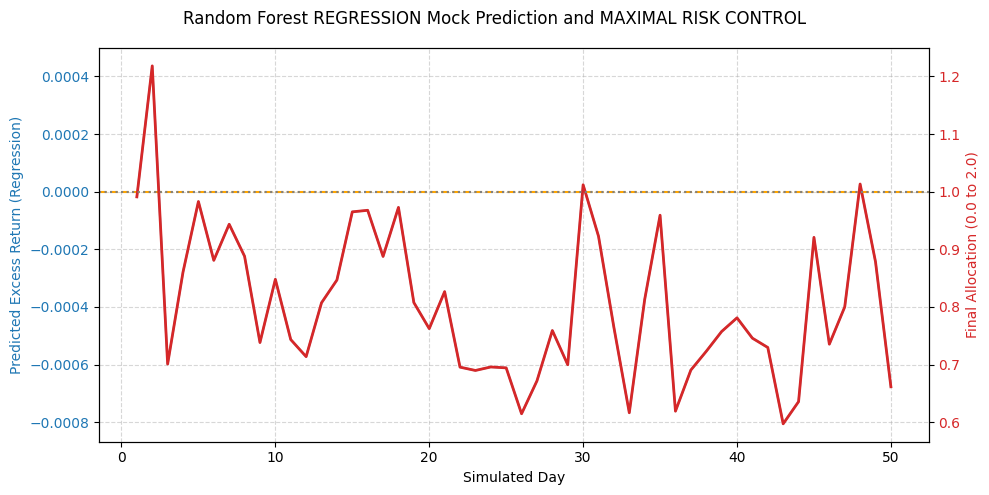

In [2]:
import os
import polars as pl
import numpy as np
import logging
from typing import List

# New Imports: Scikit-Learn RandomForestRegressor for stability
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Kaggle Evaluation API Interface (Mandatory) ---
try:
    import kaggle_evaluation.default_inference_server as inference_server
except ImportError:
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn
        def serve(self):
            logging.info("Mock Inference Server Running...")
        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")
    inference_server = MockInferenceServer

# --- Global Model Variables ---
MODEL = None
TRAIN_COLS = None
TRAIN_MEANS = None 
FEATURE_HISTORY = [] 
HISTORY_MAX_LENGTH = 100 # Max number of rows to keep for rolling feature calculation

# Set up logging
logging.basicConfig(level=logging.INFO)

# --- Feature Engineering and Selection ---

def preprocess_data(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """
    Simplified preprocessing for maximum stability. Focuses on core momentum and volatility.
    """
    
    # --- Polars Feature Engineering (Core Signals) ---
    
    # 1. Rolling Mean and Standard Deviation 
    ROLLING_WINDOWS = [10, 20] # Only use medium and long windows
    BASE_FEATURES = ['M1', 'E1', 'V1', 'S1', 'T1', 'P1', 'D1']

    expressions = []
    for window in ROLLING_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                # Rolling Mean (Momentum) 
                expressions.append(
                    pl.col(col).rolling_mean(window_size=window, min_samples=1).alias(f'{col}_roll_mean_{window}')
                )
                # Rolling Standard Deviation (Volatility)
                expressions.append(
                    pl.col(col).rolling_std(window_size=window, min_samples=1).alias(f'{col}_roll_std_{window}')
                )
    
    if expressions:
        df = df.with_columns(expressions)
        
    # --- Convert to Pandas for EMA ---
    pdf = df.to_pandas()
    
    # 2. Exponential Moving Averages (EMAs)
    EMA_WINDOWS = [10, 30] 
    for window in EMA_WINDOWS:
        for col in BASE_FEATURES:
            if col in pdf.columns:
                pdf[f'{col}_ema_{window}'] = pdf[col].ewm(span=window, adjust=False).mean()
    
    # 3. Time Feature (Only the raw date_id)
    if 'date_id' in pdf.columns:
        pdf['date_id'] = pdf['date_id']
        
    # Drop non-feature columns
    EXCLUDE_FINAL_COLS = ['forward_returns', 'risk_free_rate', 
                          'market_forward_excess_returns', 'is_scored', 
                          'lagged_forward_returns', 'lagged_risk_free_rate', 
                          'lagged_market_forward_excess_returns']
                          
    final_cols = [col for col in pdf.columns if col not in EXCLUDE_FINAL_COLS]
    
    if is_training:
        return pdf[final_cols]
    else:
        # Return the last row only for inference
        return pdf[final_cols].tail(1)


# --- Core Prediction and Allocation Logic ---

def train_model(train_df: pl.DataFrame):
    """
    Trains a Random Forest Regressor to predict the raw excess return.
    """
    global MODEL, TRAIN_COLS, TRAIN_MEANS, FEATURE_HISTORY
    
    # 1. TARGET: Predict the raw excess return (Regression)
    y_train = train_df['market_forward_excess_returns'].to_numpy()
    
    # 2. Prepare Features
    X_train_pd = preprocess_data(train_df, is_training=True)
    
    TRAIN_COLS = list(X_train_pd.columns) 
    
    # 3. Impute Data Manually
    TRAIN_MEANS = X_train_pd.mean()
    X_train_pd = X_train_pd.fillna(TRAIN_MEANS)
    
    # 4. Define and fit the Random Forest Regressor (Simpler, more robust)
    regressor = RandomForestRegressor(
        n_estimators=100,             # Fewer trees for faster and simpler model
        max_depth=5,                  # Shallow trees to avoid deep overfitting
        min_samples_leaf=20,          # High value for robust splits
        random_state=42, 
        n_jobs=4,
    )
    
    MODEL = regressor
    
    logging.info(f"Starting Random Forest training on {len(X_train_pd)} samples with {len(TRAIN_COLS)} features...")
    MODEL.fit(X_train_pd, y_train)
    logging.info("Model training complete.")
    
    # Store the tail of the training data as history 
    FEATURE_HISTORY.extend(train_df.tail(HISTORY_MAX_LENGTH).rows(named=False))


def convert_prediction_to_allocation(predicted_return: float) -> float:
    """
    Converts the model's raw predicted return into the required allocation size [0.0, 2.0].
    
    CRITICAL CHANGE: This uses the most conservative allocation multiplier yet,
    prioritizing stability over aggressive returns.
    """
    
    # MAXIMUM RISK CONTROL: The multiplier is extremely low (0.5), meaning we need a very 
    # large predicted return for the bet size to move far from 1.0 (neutral).
    CONFIDENCE_MULTIPLIER = 0.5 

    # 1. Scale the raw predicted return (which is usually small, like -0.005 to 0.005)
    # The result is our 'edge'. Note: Tanh is removed for simplicity and direct scaling.
    scaled_edge = CONFIDENCE_MULTIPLIER * predicted_return * 1000.0 # Scale return magnitude up

    # 2. Clamp the scaled edge to a safe range before adding to neutral
    scaled_edge = np.clip(scaled_edge, -0.9, 0.9)

    # 3. Map the scaled edge back to the final allocation range [0.0, 2.0]
    final_allocation = 1.0 + scaled_edge
    
    # Clip the result to the required range [0.0, 2.0]
    final_allocation = np.clip(final_allocation, 0.0, 2.0)
    
    return float(final_allocation)

# --- CRITICAL FIX: Model Setup (to avoid Kaggle startup timeout) ---
def setup_model():
    """
    Loads training data and trains the model. This is called once at script start 
    in the competition environment to run the time-consuming step before the server 
    startup timer begins.
    """
    global MODEL
    if MODEL is not None:
        return
        
    train_path = os.path.join('/kaggle/input/hull-tactical-market-prediction/', 'train.csv')
    
    try:
        logging.info("Attempting to load train.csv for pre-server setup...")
        train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
        train_model(train_df)
    except Exception as e:
        # If loading fails here, the model remains None, and predict will return neutral.
        logging.error(f"FATAL: Model setup failed. Could not load train.csv or train model: {e}")
        

# --- The Required Kaggle Inference Function ---

def predict(test: pl.DataFrame) -> float:
    """
    The main inference function called by the Kaggle evaluation API for each timestep.
    (Model training is now handled outside this function in setup_model.)
    """
    global MODEL, TRAIN_COLS, TRAIN_MEANS, FEATURE_HISTORY
    
    is_mock_run = not os.getenv('KAGGLE_IS_COMPETITION_RERUN')
    default_return = (1.0, 0.0) if is_mock_run else 1.0
    
    if MODEL is None:
        # If model is None, it means the setup_model call failed or hasn't run yet.
        logging.error("Model not initialized. Returning neutral allocation.")
        return default_return
            
    # --- CRITICAL: Update and Use Feature History for Rolling Features ---
    FEATURE_HISTORY.extend(test.rows(named=False))
    
    if len(FEATURE_HISTORY) > HISTORY_MAX_LENGTH:
        FEATURE_HISTORY = FEATURE_HISTORY[-HISTORY_MAX_LENGTH:]
        
    try:
        current_data_for_features = pl.DataFrame(
            FEATURE_HISTORY, 
            schema=test.schema 
        )
    except Exception as e:
        logging.error(f"Failed to reconstruct Polars DataFrame from history: {e}")
        return default_return
    
    # Ensure we only use the features the model was trained on
    try:
        X_test_pd = preprocess_data(current_data_for_features, is_training=False)
        
        # Check and handle missing features from simplified set
        missing_cols = set(TRAIN_COLS) - set(X_test_pd.columns)
        for col in missing_cols:
            X_test_pd[col] = np.nan
            
        X_test_pd = X_test_pd[TRAIN_COLS] # Reorder and select
        
        # IMPUTATION STEP: using TRAIN_MEANS
        if TRAIN_MEANS is not None:
             X_test_pd = X_test_pd.fillna(TRAIN_MEANS)
        else:
             X_test_pd = X_test_pd.fillna(X_test_pd.mean()) 
        
    except Exception as e:
        logging.error(f"Feature selection failed in predict: {e}")
        return default_return

    # Predict the raw market forward excess return
    try:
        predicted_return = MODEL.predict(X_test_pd)[-1]
        
        # Convert the predicted return into the final allocation
        final_allocation = convert_prediction_to_allocation(predicted_return)
        
        if is_mock_run:
             # Store both allocation and raw prediction for the mock test
             return (final_allocation, predicted_return) 
        
        return final_allocation

    except Exception as e:
        logging.error(f"Inference failed: {e}. Returning neutral allocation.")
        return default_return


# --- Visualization Helper ---

def plot_results(results_df: pd.DataFrame):
    """Generates a plot of the predicted returns and allocations."""
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Predicted Return (left axis)
    color = 'tab:blue'
    ax1.set_xlabel('Simulated Day')
    ax1.set_ylabel('Predicted Excess Return (Regression)', color=color) 
    ax1.plot(results_df['day'], results_df['predicted_return'], color=color, label='Predicted Return', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.axhline(0.0, color='orange', linestyle='--', label='Neutral Return (0.0)')

    # Plot Allocation (right axis)
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Final Allocation (0.0 to 2.0)', color=color)  
    ax2.plot(results_df['day'], results_df['allocation'], color=color, label='Final Allocation', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(1.0, color='gray', linestyle=':', label='Neutral (1.0)')

    # Title and Final Touches
    fig.suptitle('Random Forest REGRESSION Mock Prediction and MAXIMAL RISK CONTROL')
    fig.tight_layout()
    plt.show()

# --- Mock Test Runner ---
def run_mock_test_and_visualize():
    """Simulates 50 days of inference for visualization."""
    
    MOCK_FEATURES = [
        'D1', 'D2', 'E1', 'E2', 'V1', 'V2', 'S1', 'S2', 'M1', 'M2', 'T1', 'T2', 'P1', 'P2'
    ]
    
    results = []
    
    # 1. Simulate training (Call setup_model manually for mock environment)
    # The setup_model call is skipped in the mock runner below, so we manually simulate training
    # for the mock environment by constructing a mock training set and calling predict once.
    
    # Re-simulate the required training history for feature engineering
    mock_train_rows = []
    for i in range(HISTORY_MAX_LENGTH + 10):
        row = {col: [np.random.rand()] for col in MOCK_FEATURES}
        row['market_forward_excess_returns'] = [np.random.uniform(-0.005, 0.005)] 
        row['date_id'] = [1000 + i]
        mock_train_rows.append(pl.DataFrame(row))
        
    mock_train_df = pl.concat(mock_train_rows)
    # Call the train_model directly since the mock environment doesn't have train.csv path
    train_model(mock_train_df)
    
    logging.info("Model is now trained and history buffer initialized (Mock).")

    # 2. Simulate 50 days of real-time inference
    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == 'M1' else np.random.rand()] 
            for c in MOCK_FEATURES
        }
        mock_day_data['market_forward_excess_returns'] = [np.random.uniform(-0.005, 0.005)]
        mock_day_data['date_id'] = [1000 + HISTORY_MAX_LENGTH + 10 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)
        
        # Predict returns the tuple (allocation, raw_prediction) in mock mode
        allocation, predicted_return = predict(mock_test_df_day)
        
        results.append({
            'day': day + 1,
            'predicted_return': predicted_return, # Storing raw predicted return
            'allocation': allocation
        })

    # 3. Process and Plot Results
    results_df = pd.DataFrame(results)
    
    logging.info(f"\n--- MOCK TEST SIMULATION SUMMARY (50 Days) ---")
    logging.info(f"Mean Final Allocation: {results_df['allocation'].mean():.4f}")
    logging.info(f"Min/Max Allocation: {results_df['allocation'].min():.4f} / {results_df['allocation'].max():.4f}")
    logging.info("-------------------------------------------------")
    
    plot_results(results_df)

# --- Main Execution Block for Kaggle ---

inference_server_instance = inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    # CRITICAL FIX: Setup model BEFORE starting the inference server to avoid timeout.
    setup_model() 
    inference_server_instance.serve()
else:
    logging.info("Running local gateway for testing.")
    try:
        local_input_path = os.path.join(os.getcwd(), 'kaggle_input/hull-tactical-market-prediction/')
        inference_server_instance.run_local_gateway((local_input_path,))
    except Exception as e:
        logging.error(f"Local gateway simulation failed. This is expected outside Kaggle: {e}")
        
        run_mock_test_and_visualize()
        
        # --- Mandatory Dummy Submission File Generation for Kaggle System Check ---
        logging.info("Generating dummy submission.parquet for Kaggle system check.")
        dummy_submission = pl.DataFrame({
            'date_id': [999], 
            'allocation': [1.0] 
        })
        dummy_submission.write_parquet('submission.parquet')
        logging.info("submission.parquet created successfully.")
        
